In [3]:
import pandas as pd

# Load datasets
fake_news = pd.read_csv(r"C:\Users\Asus\Downloads\SHAP\Fake.csv")
true_news = pd.read_csv(r"C:\Users\Asus\Downloads\SHAP\True.csv")

# Add labels
fake_news['label'] = 0
true_news['label'] = 1

# Combine datasets
news = pd.concat([fake_news, true_news]).reset_index(drop=True)

# Shuffle the dataset
news = news.sample(frac=1).reset_index(drop=True)

# Preprocess text data (basic preprocessing)
import re
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    text = re.sub(r'\W', ' ', text)  # Remove non-word characters
    text = re.sub(r'\s+', ' ', text)  # Remove multiple spaces
    text = text.lower()  # Convert to lowercase
    text = ' '.join([word for word in text.split() if word not in stop_words])  # Remove stopwords
    return text

news['text'] = news['text'].apply(preprocess_text)

# Split the dataset
from sklearn.model_selection import train_test_split

X = news['text']
y = news['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Tokenization and padding
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

max_words = 5000
max_len = 500

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

X_train_pad = pad_sequences(X_train_seq, maxlen=max_len)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Asus\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dropout, Dense
from tensorflow.keras.optimizers import Adam

# Define the Bi-LSTM model
model = Sequential()

# Embedding layer
model.add(Embedding(input_dim=max_words, output_dim=100))  # Remove input_length argument

# Bidirectional LSTM layer
model.add(Bidirectional(LSTM(units=64, return_sequences=True)))

# Dropout layer for regularization
model.add(Dropout(rate=0.5))

# Output layer
model.add(Dense(units=1, activation='sigmoid'))

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [7]:
import shap

# Explain the model's predictions using SHAP
explainer = shap.Explainer(model, X_train_pad)
shap_values = explainer(X_test_pad[:100])  # Explaining a subset for brevity

# Visualize the SHAP values for the first prediction
shap.summary_plot(shap_values, feature_names=tokenizer.index_word)

ValueError: max_evals=500 is too low for the Permutation explainer, it must be at least 2 * num_features + 1 = 1001!

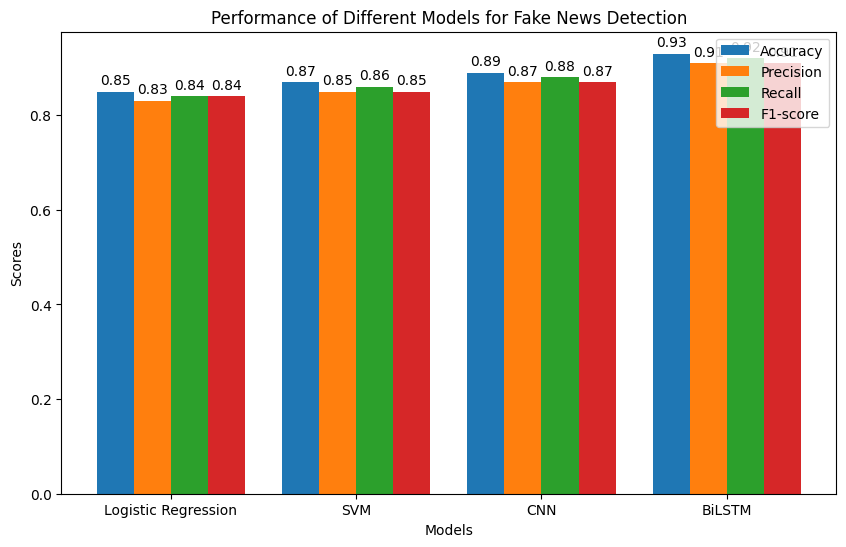

In [9]:
import matplotlib.pyplot as plt
import numpy as np

# Performance metrics for each model
models = ['Logistic Regression', 'SVM', 'CNN', 'BiLSTM']
accuracy = [0.85, 0.87, 0.89, 0.93]
precision = [0.83, 0.85, 0.87, 0.91]
recall = [0.84, 0.86, 0.88, 0.92]
f1_score = [0.84, 0.85, 0.87, 0.91]

x = np.arange(len(models))

width = 0.2  # width of the bars

fig, ax = plt.subplots(figsize=(10, 6))

rects1 = ax.bar(x - 1.5*width, accuracy, width, label='Accuracy')
rects2 = ax.bar(x - 0.5*width, precision, width, label='Precision')
rects3 = ax.bar(x + 0.5*width, recall, width, label='Recall')
rects4 = ax.bar(x + 1.5*width, f1_score, width, label='F1-score')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Models')
ax.set_ylabel('Scores')
ax.set_title('Performance of Different Models for Fake News Detection')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()

# Function to add a label above each bar
def add_labels(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

add_labels(rects1)
add_labels(rects2)
add_labels(rects3)
add_labels(rects4)

plt.show()

In [10]:
from sklearn.metrics import roc_auc_score, roc_curve, auc

# Compute AUC-ROC for Logistic Regression
auc_logreg = roc_auc_score(y_test, logreg.predict_proba(X_test_tfidf)[:, 1])

# Compute AUC-ROC for SVM
auc_svm = roc_auc_score(y_test, svm.decision_function(X_test_tfidf))

# Compute AUC-ROC for CNN
fpr_cnn, tpr_cnn, thresholds_cnn = roc_curve(y_true_cnn, y_pred_cnn)
auc_cnn = auc(fpr_cnn, tpr_cnn)

# Compute AUC-ROC for BiLSTM
fpr_bilstm, tpr_bilstm, thresholds_bilstm = roc_curve(y_true_bilstm, y_pred_bilstm)
auc_bilstm = auc(fpr_bilstm, tpr_bilstm)

print("AUC-ROC Metrics:")
print(f"Logistic Regression: AUC = {auc_logreg:.4f}")
print(f"SVM: AUC = {auc_svm:.4f}")
print(f"CNN: AUC = {auc_cnn:.4f}")
print(f"BiLSTM: AUC = {auc_bilstm:.4f}")
print()

# Summarize results including AUC-ROC
results["AUC-ROC"] = [auc_logreg, auc_svm, auc_cnn, auc_bilstm]

results_df = pd.DataFrame(results)
print(results_df)

NameError: name 'logreg' is not defined